We want to examine the distributions of the input variables for signal and background events. Look for regions of the input space where signal events tend to have different characteristics than background events. Based on this, define selection cuts for each input variable to separate signal from background.

Another way, is to do a BDT process. For this, we will use the Cross-validation, which is a technique where you divide your available data into multiple subsets for training and testing. This can help mitigate the risk of overfitting and give a better estimate of your model's performance on unseen data.
We'll perfom cross-validation using a combination of MC and real data to get a more comprehensive evaluation of theclassifier's performance.

We added the libraries we'll need.

In [3]:
import mplhep as hep
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

Now let’s plot the variables in signal and background to see what they look like. (Density of data)

In [4]:
##MC DATA
%store -r njsig
%store -r njbkg
%store -r nbjsig 
%store -r nbjbkg
%store -r htbsig 
%store -r htbbkg 
%store -r htratsig
%store -r htratbkg 
##REAL DATA
%store -r njdata 
%store -r nbjdata
%store -r htbdata
%store -r htratdata

print(len(njsig))
print(len(njbkg))
print(len(nbjsig))
print(len(nbjbkg))


30769
819301
30769
819301


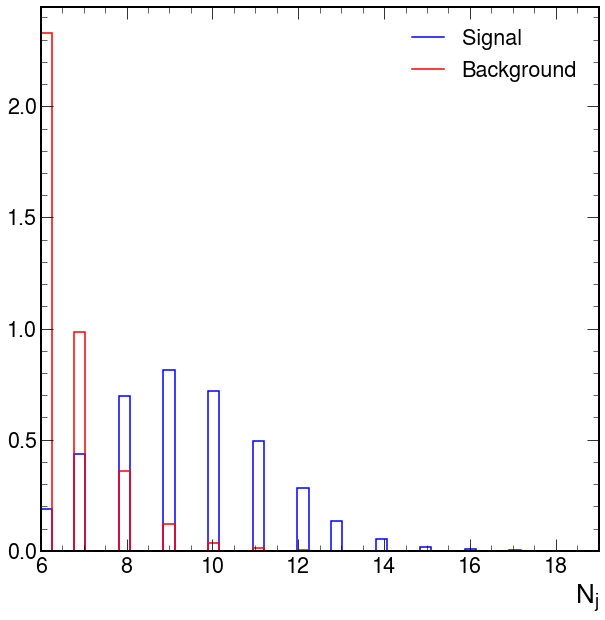

In [5]:
plt.style.use(hep.style.CMS)

njsig, bins = np.histogram(njsig, bins=50)
njbkg, bins = np.histogram(njbkg, bins=bins)  

hep.histplot(njsig, bins=bins, label='Signal', density=1, color='blue')
hep.histplot(njbkg, bins=bins, label='Background', density=1, color='red')
plt.xlabel('$N_j$')
plt.xlim(bins[0], bins[-1])
plt.legend(loc='best')

In [6]:
def plot_comparision(var1,var2,var1_sig, var2_sig, var1_bkg, var2_bkg):

    plt.scatter(var1_sig, var2_sig, color='blue', label='Signal', alpha=0.5)
    plt.scatter(var1_bkg, var2_bkg, color='red', label='Background',alpha=0.5)
    # Add labels and legend
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend(loc='best')
    plt.show()

ValueError: x and y must be the same size

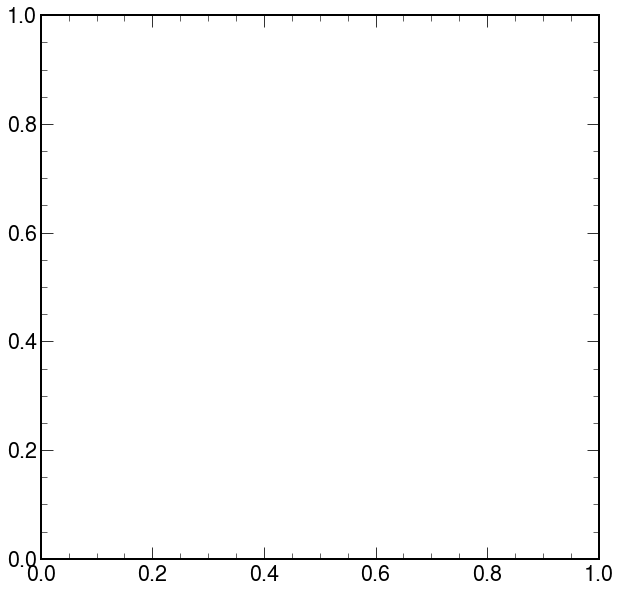

In [9]:
plot_comparision('$Ht$','$Nb_J$', htbsig, htratsig, htbbkg, htratbkg)

Lets create some data frames that would be useful. 

Monte-Carlo data for the training:

In [8]:
signal_data = {'nj': njsig, 'nbj': nbjsig, 'htb':htbsig, 'htrat':htratsig} ##mc data
background_data = {'nj': njbkg, 'nbj': nbjbkg, 'htb':htbbkg, 'htrat':htratbkg} ##mc data

sig_df = pd.DataFrame(signal_data)
bkg_df = pd.DataFrame(background_data)

In [9]:
training_columns=['nj','nbj','htb','htrat']

%store training_columns
print(training_columns)

Stored 'training_columns' (list)
['nj', 'nbj', 'htb', 'htrat']


In [10]:
bkg_df = bkg_df.copy()
bkg_df['catagory'] = 0  # Use 0 for background
sig_df['catagory'] = 1  # Use 1 for signal

In [12]:
# Now merge the data together
training_data = pd.concat([bkg_df, sig_df], copy=True, ignore_index=True)

# Store training_data for later
%store training_data


Stored 'training_data' (DataFrame)


Now, lets create the data that will serve for testing. We use for this the real data.

In [13]:
data = {'nj': njdata, 'nbj': nbjdata, 'htb':htbdata, 'htrat':htratdata}
data_df = pd.DataFrame(data)

Lets define the BDT we will use and train it with a fit fuction using the training data

In [48]:
# Train the Gradient Booster
bdt_1 = GradientBoostingClassifier()
bdt_1.fit(training_data[training_columns], training_data['catagory'])

data_df['BDT1'] = bdt_1.predict_proba(data_df[training_columns])[:,1]
sig_df['BDT1']= bdt_1.predict_proba(data_df[training_columns])[:,1]


In [49]:
# Train the Adaptive Booster
bdt_2 = AdaBoostClassifier()
bdt_2.fit(training_data[training_columns], training_data['catagory'])

data_df['BDT2'] = bdt_2.predict_proba(data_df[training_columns])[:,1]

In [50]:
# Train XGBoost Classifier
bdt_3 = XGBClassifier()
bdt_3.fit(training_data[training_columns], training_data['catagory'])

data_df['BDT3'] = bdt_3.predict_proba(data_df[training_columns])[:,1]


### ROC CURVE

Lets calculate and plot the roc curve for each bdt.

In [17]:
plt.style.use(hep.style.CMS)
def plot_roc(bdt):
    y_score = bdt.predict_proba(data_df[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)
    area = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label:
        plt.plot(fpr, tpr, label=f'{label} (area = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')

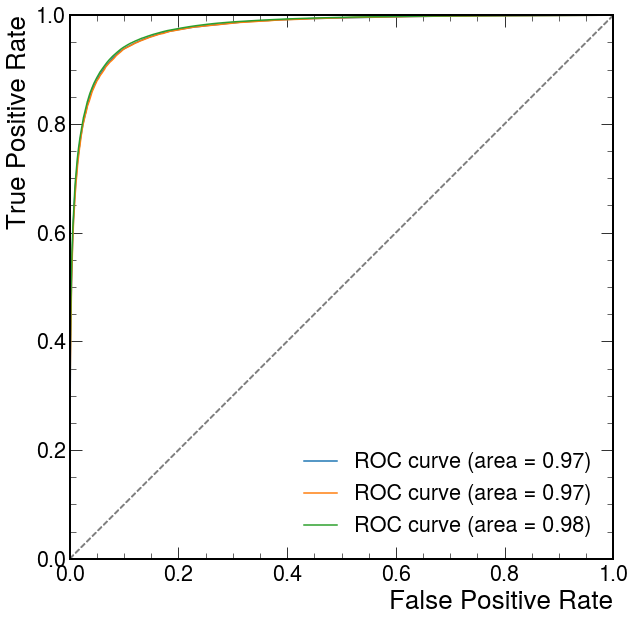

In [20]:
for bdt in [bdt_1, bdt_2, bdt_3]:
    plot_roc(bdt)
 
plt.show()

In [46]:
def plot_comparision(var, mc_df, bkg_df):
    # create histograms
    hsig, bins = np.histogram(mc_df[var], bins=60, density=1)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=1)
    
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Calculate square root of counts for error bars
    hsig_err = np.sqrt(hsig)
    hbkg_err = np.sqrt(hbkg)
    
    plt.style.use(hep.style.CMS)
    plt.errorbar(bin_centers, hsig, yerr=hsig_err, label='DATA', fmt='.', color='black')
    plt.errorbar(bin_centers, hbkg, yerr=hbkg_err, label='MC Bkg', fmt='.', color='black')

    hep.histplot((hsig, bins), label='DATA', color='blue' )
    hep.histplot(hbkg, bins=bins, label='MC Bkg', color='red')
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')

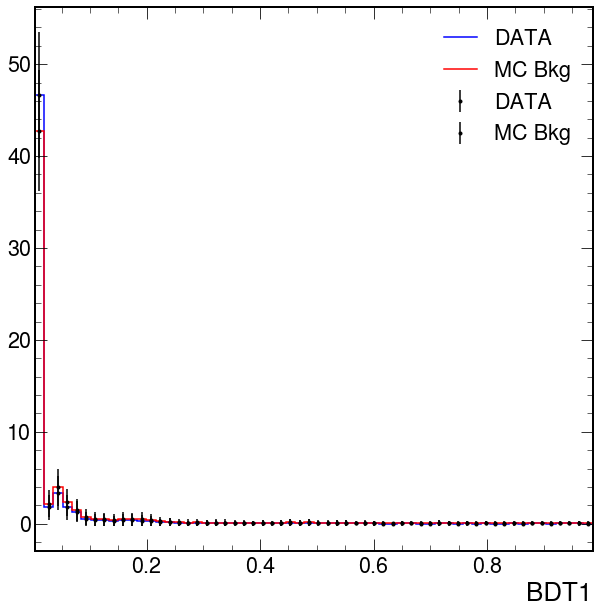

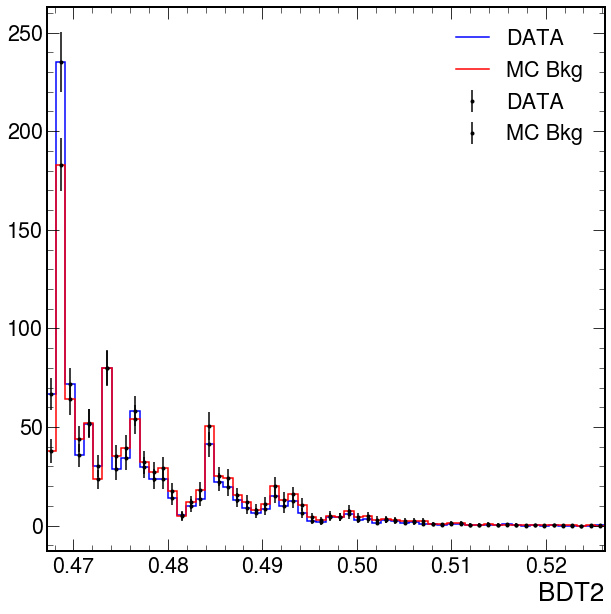

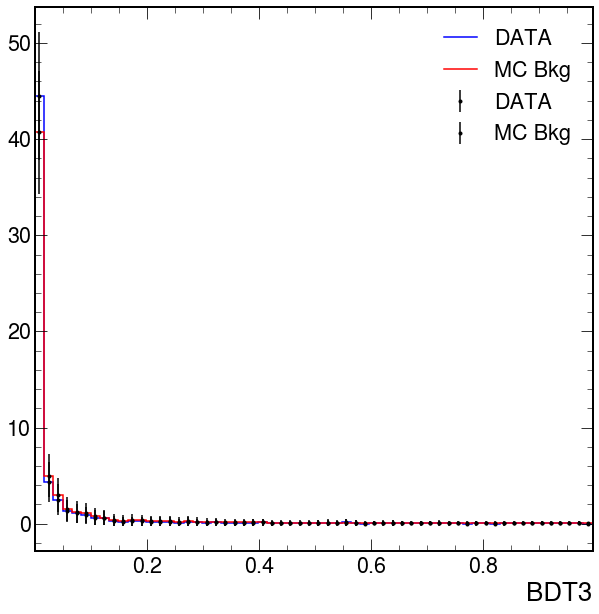

In [47]:
plt.figure()
plot_comparision('BDT1', data_df, bkg_df)
plt.figure()
plot_comparision('BDT2', data_df, bkg_df)
plt.figure()
plot_comparision('BDT3', data_df, bkg_df)


Make probability predictions on new data using the trained GradientBoostingClassifier model:

In [30]:
predicted_probs = bdt_3.predict_proba(data_df[training_columns])[:, 1]

Extract the probabilities for each column (of it being 0 for the first, or one for the second) for each event. Now a vector is created containing only the predicted probabilities for when it is 1 (signal).

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


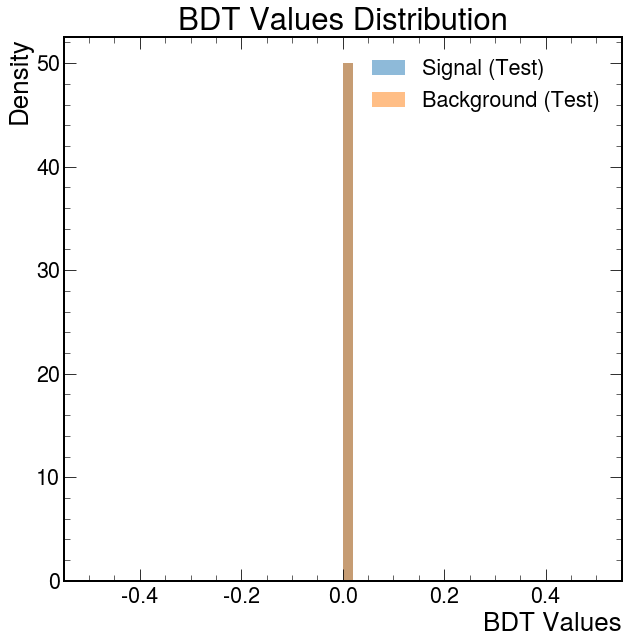

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the BDT values for signal and background
plt.hist(predicted_probs == 1, bins=50, density=True, alpha=0.5, label='Signal (Test)')
plt.hist(predicted_probs == 0, bins=50, density=True, alpha=0.5, label='Background (Test)')

plt.xlabel('BDT Values')
plt.ylabel('Density')
plt.legend()
plt.title('BDT Values Distribution')
plt.show()

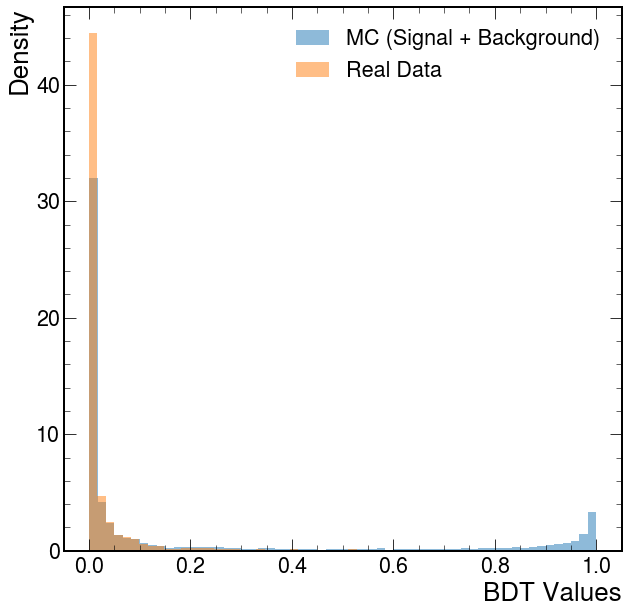

In [98]:
bdt_values_mc = np.concatenate([sig_df['BDT'], bkg_df['BDT']])
bdt_values_data = data_df['BDT']

plt.hist(bdt_values_mc, bins=60, density=True, alpha=0.5, label='MC (Signal + Background)')
plt.hist(bdt_values_data, bins=60, density=True, alpha=0.5, label='Real Data')
plt.xlabel('BDT Values')
plt.ylabel('Density')
plt.legend()
plt.show()

In [74]:
def plot_comparision(var, mc_df, bkg_df):
    # create histograms
    hsig, bins = np.histogram(mc_df[var], bins=60, density=1)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=1)

    hep.histplot((hsig, bins), label='Data', color='blue' )
    hep.histplot(hbkg, bins=bins, label='MC Background', color='red')
    plt.xlabel(var)
    #plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')

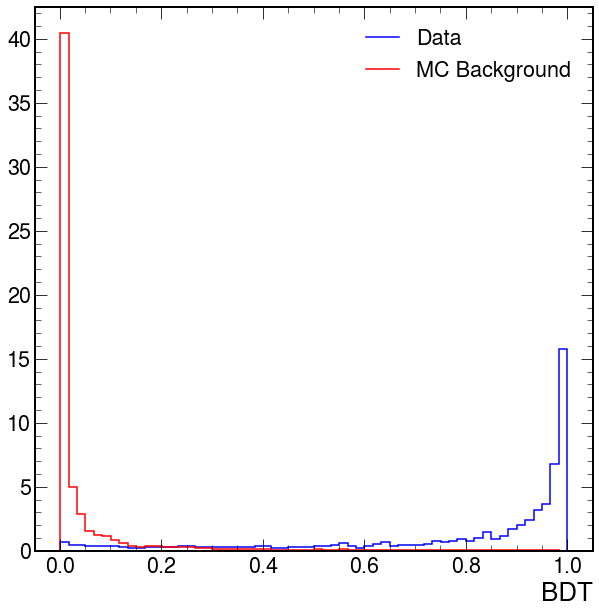

In [77]:
plot_comparision('BDT', sig_df, bkg_df)

      nj  nbj          htb     htrat       BDT
305    9    1   548.000000  0.285893  0.927195
440    7    4   316.250000  0.498298  0.874278
764    7    4   327.625000  0.380377  0.837582
837    9    2   299.968750  0.468935  0.907763
1323   7    1   751.000000  0.062988  0.880601
1372   8    2   100.812500  0.117923  0.804346
1444  11    1   147.500000  0.720401  0.973454
1758   9    2   196.750000  0.479004  0.852671
1808   9    4  1042.031250  0.212014  0.995330
1898   8    2   471.000000  0.316144  0.835776
2071   7    3   530.562500  0.392370  0.926345
2137  10    2   145.593750  0.816712  0.907277
2435  10    3   218.656250  0.419701  0.975219
2723   9    2   161.062500  0.308415  0.848024
3236   7    3   570.500000  0.244701  0.862229
3323   8    4   229.406250  0.571091  0.886631
3480   9    1   202.750000  0.384264  0.866259
3529   9    2   358.937500  0.451458  0.912607
3699   8    3   298.750000  0.610736  0.874887
3816   7    4   502.968750  0.198657  0.886506
4029   9    2

Text(1, 0, 'Nj')

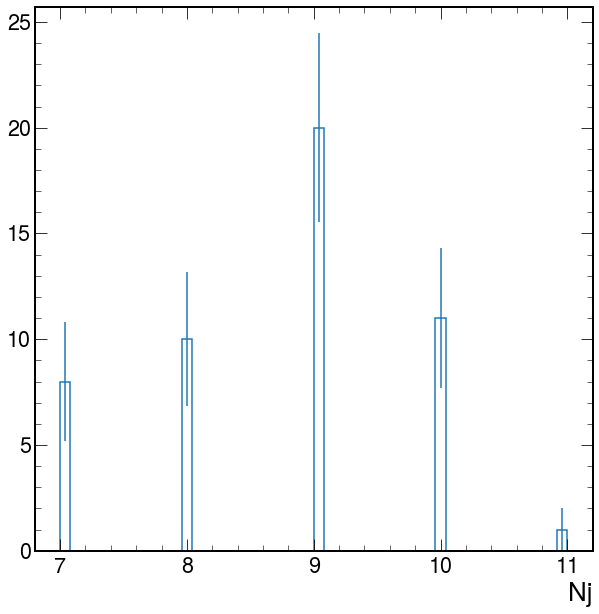

In [81]:
data_with_cuts_df = data_df.query('BDT > 0.8')
print(data_with_cuts_df)

#plt.style.use(hep.style.CMS)
h, bins = np.histogram(data_with_cuts_df['nj'], bins=50)
hep.histplot(h, bins, yerr=True)  
plt.xlabel('Nj')
#plt.xlim(bins[0], bins[-1])

Test the Model:

In [82]:
y_score = bdt.predict_proba(training_data[training_columns])[:,1]
fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

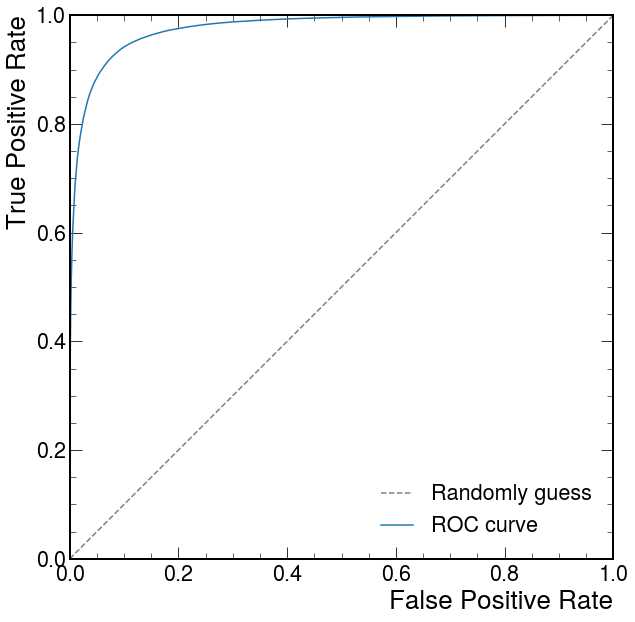

In [83]:
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Randomly guess')
plt.plot(fpr, tpr, label=f'ROC curve')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
# We can make the plot look nicer by forcing the grid to be square
plt.gca().set_aspect('equal', adjustable='box')